In [2]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import seaborn as sns
from scipy import stats
import subprocess
import os
import pandas as pd

import utilsV3
import optimizationV3
import utils
import datetime

reload(utils)
reload(utilsV3)
reload(optimizationV3)


ORIGINAL_DIM = 640

def create_objf(is_extended=True):
    D = utilsV3.CriteriaD(is_extended)
    F = utilsV3.CriteriaF(D)
    return D, F

def create_dim_red(reduced_dim):
    return utils.SegmentsDimReduction(ORIGINAL_DIM, reduced_dim)

def create_objf_reduced(f, reduced_dim):
    return utilsV3.ReducedDimObjFunSRON(reduced_dim, f)

def create_objf_profiled(f, config):
    return utilsV3.ProfiledF(f, config)

def get_datetime_str():
    return datetime.datetime.now().strftime('%d-%m-%Y_%Hh%Mm%Ss')

def create_distance(f, d0_method, d1_method):
    dist_matrix = utils.create_dist_matrix(f, d0_method)
    dist = utils.create_distance(f, dist_matrix, d1_method)
    return dist_matrix, dist

def create_dist_matrix_sorted(dist_matrix):
    return utilsV3.sort_dist_matrix(dist_matrix)

def crop_pdf(pdfname):
    subprocess.run(['pdfcrop', pdfname])

In [51]:
dim_red_16 = create_dim_red(16)
D, F = create_objf(True)
D_old, F_old = create_objf(False)
Fr = create_objf_reduced(F, 16)
Fr_old = create_objf_reduced(F_old, 16)
dist_matrix_2, dist_2_kirill = create_distance(F, '2', 'kirill')
dist_matrix_2_sorted = create_dist_matrix_sorted(dist_matrix_2)
dist_matrix_3, dist_3_kirill = create_distance(F, '3', 'kirill')
dist_matrix_3_sorted = create_dist_matrix_sorted(dist_matrix_3)
LIBRARY_SIZE = F.instrument.filterlibrarysize


Loading radiance model...
Loading filter library...
Loading radiance model...
Loading filter library...


In [3]:
with open('sron-baseline-extended-samples.csv', 'r') as file:
    x0_samples = np.array([float(v) for v in file.readline().split(' ')])
sron_mean = np.mean(x0_samples**2)
sron_std = np.std(x0_samples**2)

In [4]:
latex_preambula = r'''
\usepackage{graphicx}
\usepackage{multirow}
\usepackage{amsmath,amssymb,amsfonts,amsthm}
\usepackage{bm}
\usepackage{xspace}
\usepackage{ marvosym }

\DeclareMathOperator{\E}{E}
\DeclareMathOperator{\Var}{Var}

\DeclareMathOperator{\Eest}{\widehat{E}}
\DeclareMathOperator{\Varest}{\widehat{Var}}

\newcommand{\N}{\mathbb{N}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\Z}{\mathbb{Z}}

\newcommand\inner[2]{\left\langle #1, #2 \right\rangle}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\br}[1]{\left(#1\right)}
\newcommand{\cl}[1]{\left[#1\right]}
\renewcommand{\epsilon}{\varepsilon}
\newcommand{\eps}{\varepsilon}
\renewcommand{\mid}{\,\middle\vert\,}
\newcommand{\Span}[1]{\ensuremath{\operatorname{span}\set{#1}}} % linear span
\newcommand{\rank}{\ensuremath{\operatorname{rank}}}
\newcommand{\Sdiv}{\ensuremath{\mathrm{D}}}
\newcommand{\NP}{\ensuremath{\mathcal{NP}}\xspace}

\newcommand{\F}{\ensuremath{\mathrm{F}}\xspace}
\newcommand{\Fest}{\ensuremath{\widehat{\mathrm{F}}}\xspace}

\newcommand{\BF}[1]{
	\relax
	\ifmmode
	\ifcat\noexpand#1\relax %
		\boldsymbol{#1}     %
	\else
		\mathbf{#1}
	\fi
	\else
		\textbf{#1}
	\fi
}
'''
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=latex_preambula)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 15

In [5]:
patches = []
name_to_color = {}

In [92]:
def build_plot(processed_csv, basepdfname, mode):
    colors = mpl.cm.jet(np.linspace(0, 1, len(set(processed_csv))))
    # colors[2] = mpl.cm.jet(2.7/7)
    # colors[5] = mpl.cm.jet(0.8)
    sron_guess = x0_samples**2

    global patches, name_to_color
    if mode != 'legend':
        patches.clear()
        name_to_color.clear()

    fig = plt.figure()
    ax = plt.gca()
    ax.set_yscale('log')
    cut_tail = 2100
    cut_tail_bo = 1000
    bo_pos_in_list = -1
    if mode == 'best-so-far':
        LW = 3
    else:
        LW = 3
    for i, (f, label) in enumerate(processed_csv):
        alg_name = os.path.basename(f).split('.')[0]  
        if alg_name == 'bo-sk':
            cut_tail = cut_tail_bo
            bo_pos_in_list = i
        else:
            cut_tail = 2100          
        df = pd.read_csv(f, sep=' ')
        x = df['iteration'][:cut_tail]
        y = df['mean'][:cut_tail]
        min_ = df['mean_best_so_far'][:cut_tail]
        # err = df['std'][:cut_tail]/np.sqrt(df['cnt'][:cut_tail])
        name_to_color[label] = colors[i]
        if mode != 'legend':
            if mode == 'mean':
                values = y
                err = 0
            elif mode == 'best-so-far':
                values = min_
                err = df['std_best_so_far'][:cut_tail]
            if label == 'NGOpt':
                patch, = plt.plot(x, values, 'd', markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)
            # elif label == 'Integer Fast GA':
            #     patch, = plt.plot(x, values, 'X', markersize=10, markevery=90, ls='-', c=colors[i], label=label, lw=LW)
            elif label == '$(\mu/2, \lambda)$ MIES':
                patch, = plt.plot(x, values, 's', markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)
            elif label == '$(\mu + \lambda)$ EA':
                patch, = plt.plot(x, values, 's', markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)                
            elif label == '$(\mu/2 + \lambda)$ EA':
                patch, = plt.plot(x, values, 'd', markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)                
            elif label == 'DD-$(\mu/2 + \lambda), d_1$ EA' or label == 'DD-$(\mu/2 + \lambda), d_2$ EA':
                patch, = plt.plot(x, values, 'd', markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)
            elif label == 'UMDA' and not 'improved' in basepdfname:
                patch, = plt.plot(x, values, "|", markersize=20, markevery=70, ls='-', c=colors[i], label=label, lw=LW)
            elif label == 'UMDA' and 'improved' in basepdfname:
                patch, = plt.plot(x, values, "|", markersize=20, markevery=70, ls='-', c=colors[i], label=label, lw=3*LW)
            elif label == 'UMDA-U':
                patch, = plt.plot(x, values, "o", markersize=10, markevery=100, ls='-', c=colors[i], label=label, lw=LW)
            else:
                patch, = plt.plot(x, values, c=colors[i], label=label, lw=LW)
            if mode == 'best-so-far':
                ax.fill_between(x, values - err, values + err, facecolor=colors[i], alpha=0.20) 
            patches.append(patch)
            # print(patch.get_lw())

        # x_ = df.loc[:, 'argmin_x0':'argmin_x639']
        # argmin1 = np.argmin(min_)
        # print(alg_name)
        # print(min_[argmin1])
        # print(x_.iloc[argmin1].to_list())

    sron_guess_mean = np.mean(sron_guess)
    sron_guess_std = np.std(sron_guess)/np.sqrt(len(sron_guess))
    if mode != 'legend':
        patch = plt.axhline(y=sron_guess_mean,color='black', linestyle='dashed', label='SRON baseline')
        patches.append(patch)
        # plt.fill_between(x, [sron_guess_mean - sron_guess_std]*len(x), [sron_guess_mean + sron_guess_std]*len(x), facecolor='black', alpha=0.20)
        if bo_pos_in_list != -1:    
            patch = plt.axvline(x=cut_tail_bo, color=colors[bo_pos_in_list], linestyle='dashed', label='BO max budget')
            patches.append(patch)
    if mode == 'mean':
        # plt.ylabel(r'Mean $\Fest_K$ per evaluation: $ \Eest_n \left( \mathrm{f}^{(t)}\!\cl{A(\xi)} \right) $', labelpad=10, fontsize=12)
        # plt.ylabel(r'$ \Eest_n \left( \mathrm{f}^{(t)}\!\cl{A(\xi)} \right) $', labelpad=10, fontsize=15)
        pass
    elif mode == 'best-so-far':
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        # plt.ylabel(r'Mean best-so-far $\Fest_K$ per evaluation: $ \Eest_n \left( \mathrm{g}^{(t)}\!\cl{A(\xi)} \right) $ ', labelpad=20, fontsize=12, rotation=270)
        # plt.ylabel(r'$ \Eest_n \left( \mathrm{g}^{(t)}\!\cl{A(\xi)} \right) $', labelpad=25, fontsize=15, rotation=270)
    plt.xlabel('Number of $\Fest_K$ evaluations: $t$', fontsize=15)
    plt.ylim(10**(-4), 10**(-1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    if mode != 'legend':
        # plt.legend()
        pdfname = f'{basepdfname}-{mode}.pdf'
    else:
        ax.set_axis_off()
        for p in patches:
            p.set_lw(2)
        plt.legend(patches, [p.get_label() for p in patches], ncol=5)
        pdfname = f'{basepdfname}-legend.pdf'
    fig.savefig(pdfname, bbox_inches='tight')
    subprocess.run(['pdfcrop', pdfname])


In [41]:
print('matplotlib: {}'.format(mpl.__version__))

matplotlib: 3.7.2


PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-initial-mean-crop.pdf'.
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-initial-best-so-far-crop.pdf'.
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-initial-legend-crop.pdf'.
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-improved-mean-crop.pdf'.
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-improved-best-so-far-crop.pdf'.
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `dynamics-improved-legend-crop.pdf'.


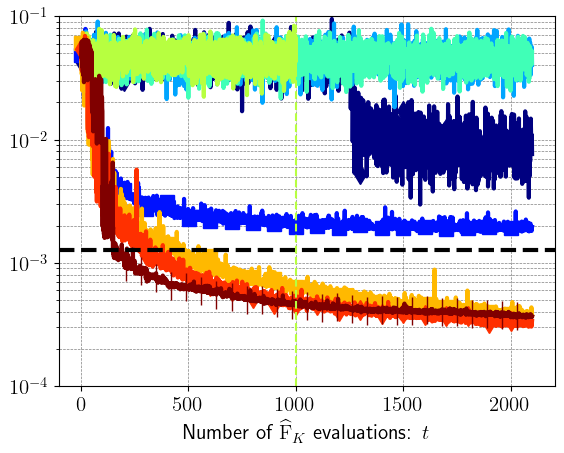

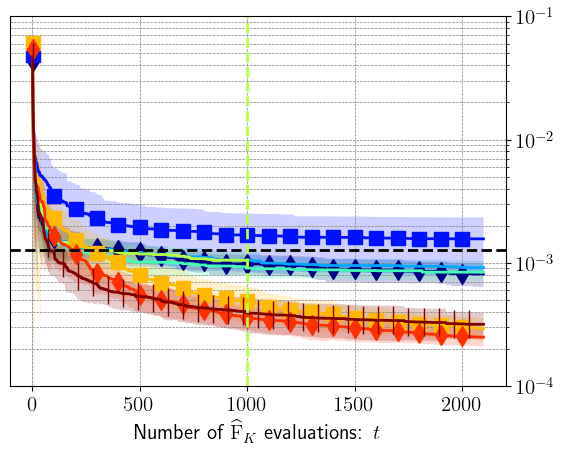

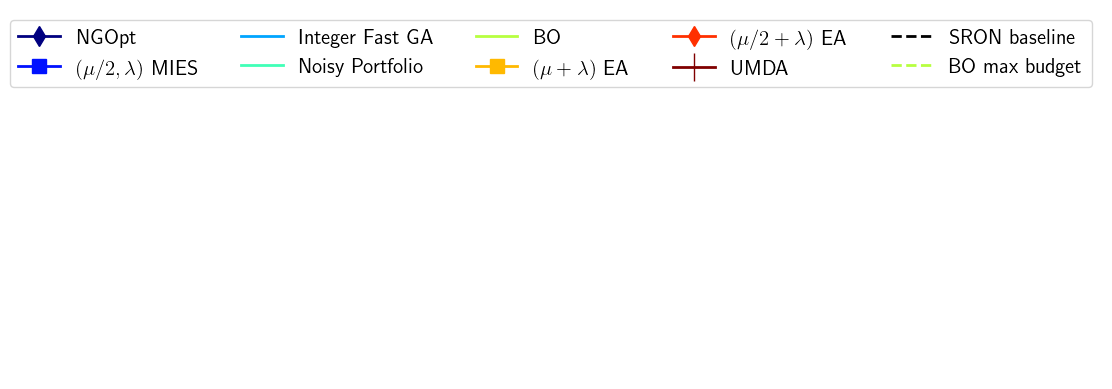

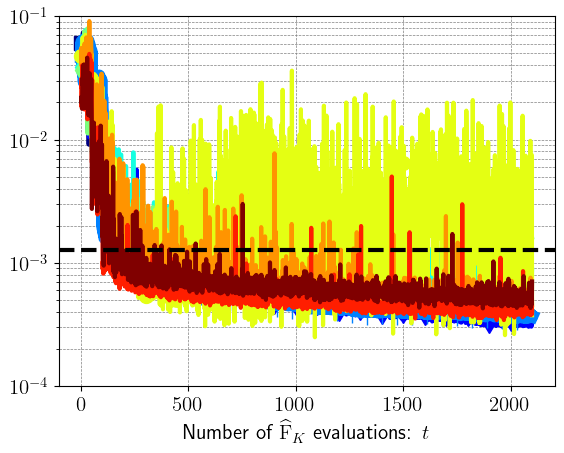

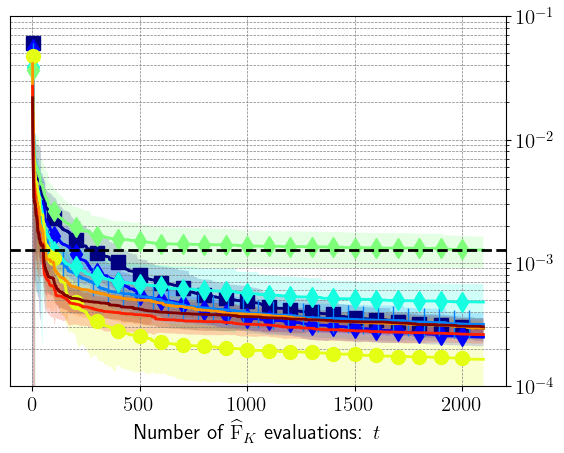

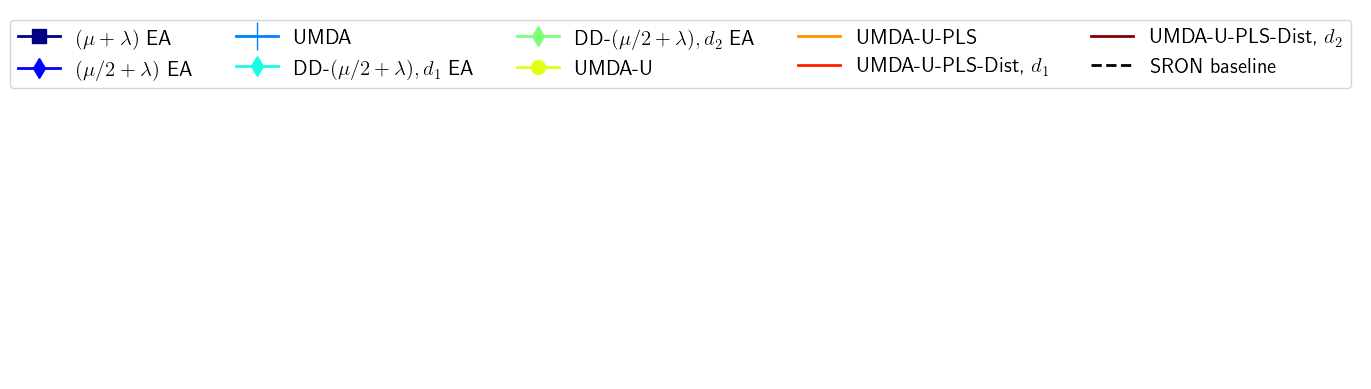

In [93]:
def build_all():
    initial_algs_csv = [
        ('processedAfter-22-05-2024/ngopt.csv', r'NGOpt'), 
        ('processedAfter-22-05-2024/mies.csv', r'$(\mu/2, \lambda)$ MIES'), 
        ('processedAfter-22-05-2024/fastga-ng.csv', r'Integer Fast GA'), 
        ('processedAfter-22-05-2024/portfolio.csv', r'Noisy Portfolio'), 
        ('processedAfter-22-05-2024/bo-sk.csv', r'BO'),
    ]
    leading_algs_csv = [
        ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
        ('processedAfter-22-05-2024/ea-simple-cross_new.csv', r'$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/umda.csv', r'UMDA'),
    ]
    extended_algs_csv = [
        # ('processedAfter-22-05-2024/dd-ga.csv', r'DD-$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/dd-ga_d0-2_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_a$ EA'),
        ('processedAfter-22-05-2024/dd-ga_d0-3_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_b$ EA'),
        ('processedAfter-22-05-2024/umda1.csv', r'UMDA-U'),
        ('processedAfter-22-05-2024/umda2.csv', r'UMDA-U-PLS'),
        ('processedAfter-22-05-2024/umda2-dist_d0-3.csv', r'UMDA-U-PLS-Dist, $d_b$'),
    ]
    top_alg = ('processedAfter-22-05-2024/umda2-dist_d0-2_new.csv', r'UMDA-U-PLS-Dist, $d_a$')

    compared_algs = initial_algs_csv + leading_algs_csv + extended_algs_csv + [top_alg]
    basepdfname = 'dynamics-all'
    build_plot(compared_algs, basepdfname, 'mean')
    build_plot(compared_algs, basepdfname, 'best-so-far')
    build_plot(compared_algs, basepdfname, 'legend')
    
    
def build_initial():
    initial_algs_csv = [
        ('processedAfter-22-05-2024/ngopt.csv', r'NGOpt'), 
        ('processedAfter-22-05-2024/mies.csv', r'$(\mu/2, \lambda)$ MIES'), 
        ('processedAfter-22-05-2024/fastga-ng.csv', r'Integer Fast GA'), 
        ('processedAfter-22-05-2024/portfolio.csv', r'Noisy Portfolio'), 
        ('processedAfter-22-05-2024/bo-sk.csv', r'BO'),
    ]
    leading_algs_csv = [
        ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
        ('processedAfter-22-05-2024/ea-simple-cross_new.csv', r'$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/umda.csv', r'UMDA'),
    ]
    compared_algs = initial_algs_csv + leading_algs_csv
    basepdfname = 'dynamics-initial'
    build_plot(compared_algs, basepdfname, 'mean')
    build_plot(compared_algs, basepdfname, 'best-so-far')
    build_plot(compared_algs, basepdfname, 'legend')
    

def build_improved():
    leading_algs_csv = [
        ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
        ('processedAfter-22-05-2024/ea-simple-cross_new.csv', r'$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/umda.csv', r'UMDA'),
    ]
    extended_algs_csv = [
        # ('processedAfter-22-05-2024/dd-ga.csv', r'DD-$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/dd-ga_d0-2_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_1$ EA'),
        ('processedAfter-22-05-2024/dd-ga_d0-3_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_2$ EA'),
        ('processedAfter-22-05-2024/umda1.csv', r'UMDA-U'),
        ('processedAfter-22-05-2024/umda2.csv', r'UMDA-U-PLS'),
        ('processedAfter-22-05-2024/umda2-dist_d0-2_new.csv', r'UMDA-U-PLS-Dist, $d_1$'),
        ('processedAfter-22-05-2024/umda2-dist_d0-3.csv', r'UMDA-U-PLS-Dist, $d_2$'),
    ]
    compared_algs = leading_algs_csv + extended_algs_csv
    basepdfname = 'dynamics-improved'
    build_plot(compared_algs, basepdfname, 'mean')
    build_plot(compared_algs, basepdfname, 'best-so-far')
    build_plot(compared_algs, basepdfname, 'legend')

build_initial()
build_improved()

In [10]:
def reorder(a, ids):
    return [a[i] for i in ids]


def get_values(f_name, BUDGET):
    f1, name = f_name
    INF = float("inf")

    df1 = pd.read_csv(f1, sep=' ')
    NINCTANCES = max(df1['cnt'].to_numpy(dtype=int))
    best_so_far = np.full(NINCTANCES, INF)
    for i in range(1, BUDGET + 1):
        values1 = df1.loc[df1['iteration'] == i].loc[:, 'eval_in_instance_0':f'eval_in_instance_{NINCTANCES-1}'].to_numpy(dtype=float)[0]
        for j in range(NINCTANCES):
            best_so_far[j] = min(best_so_far[j], values1[j])
    return best_so_far


def stat_comp(f1, fs, budget, pdfname='final-stat.pdf', styled=False, rotation=0, custom_legend=False):
    values1 = get_values(f1, budget)
    names = [f1[1]]
    x = [values1]
    stat_tests = []
    for f2 in fs:
        values2 = get_values(f2, budget)
        x.append(values2)
        stat_res = stats.mannwhitneyu(values1, values2, alternative='less', method='exact')
        stat_tests.append(stat_res)
        names.append(f2[1])
    fig = plt.figure()
    ax = plt.gca()
    sortedids = np.argsort([np.mean(d) for d in x[1:]]) + 1
    stat_tests = reorder(stat_tests, sortedids - 1)
    sortedids = np.concatenate(([0], sortedids))
    bplot = ax.boxplot(reorder(x,sortedids), notch=True, vert=True, showfliers=False, patch_artist=True, 
                    #    usermedians=[np.mean(d) for d in x], 
                       labels=reorder(names,sortedids))
    if not styled:
        plt.xticks(rotation=90)
        plt.axhline(y=np.mean(x0_samples**2), color='black', linestyle='dashed', label='SRON baseline')
        plt.legend()
    if styled:
        for patch, name in zip(bplot['boxes'], reorder(names,sortedids)):
            patch.set_facecolor(name_to_color[name])
        plt.xticks(rotation=rotation)
    if custom_legend:
        plt.legend(patches, [p.get_label() for p in patches], ncol=1)
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    ax.axvline(x=1.5,color='red',linestyle='dashed', label='Sep')
    plt.show()
    fig.savefig(pdfname, bbox_inches='tight')
    crop_pdf(pdfname)
    return stat_tests

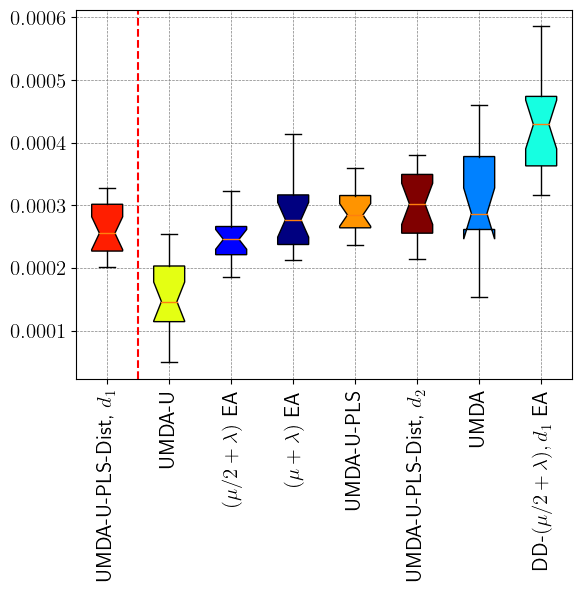

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `final-stat-crop.pdf'.
MannwhitneyuResult(statistic=349.0, pvalue=0.9999921768287579)
MannwhitneyuResult(statistic=233.0, pvalue=0.8155688022278919)
MannwhitneyuResult(statistic=145.0, pvalue=0.07085251537057889)
MannwhitneyuResult(statistic=117.0, pvalue=0.012233861341565554)
MannwhitneyuResult(statistic=107.0, pvalue=0.0056033836442019435)
MannwhitneyuResult(statistic=106.0, pvalue=0.005157018766343135)
MannwhitneyuResult(statistic=3.0, pvalue=5.078111186347389e-11)


In [11]:
def doStatComp():
    leading_algs_csv = [
        ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
        ('processedAfter-22-05-2024/ea-simple-cross_new.csv', r'$(\mu/2 + \lambda)$ EA'),
        ('processedAfter-22-05-2024/umda.csv', r'UMDA'),
    ]
    extended_algs_csv = [
        ('processedAfter-22-05-2024/dd-ga_d0-2_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_1$ EA'),
        # ('processedAfter-22-05-2024/dd-ga_d0-3_scaling-100.csv', r'DD-$(\mu/2 + \lambda), d_b$ EA'),
        ('processedAfter-22-05-2024/umda1.csv', r'UMDA-U'),
        ('processedAfter-22-05-2024/umda2.csv', r'UMDA-U-PLS'),
        ('processedAfter-22-05-2024/umda2-dist_d0-3.csv', r'UMDA-U-PLS-Dist, $d_2$'),
    ]

    top_alg = ('processedAfter-22-05-2024/umda2-dist_d0-2_new.csv', r'UMDA-U-PLS-Dist, $d_1$')
    processed_csv = leading_algs_csv + extended_algs_csv

    stats = stat_comp(top_alg, 
              processed_csv,
              2100,
              pdfname='final-stat.pdf',
              styled=True,
              rotation=90,
              custom_legend=False)
    print(*stats, sep='\n')
    
doStatComp()

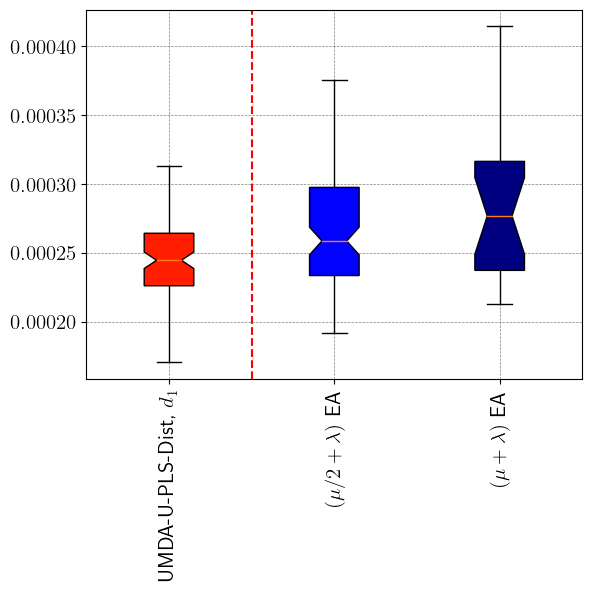

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `final-stat-top3-crop.pdf'.


[MannwhitneyuResult(statistic=3951.0, pvalue=0.005101331015197491),
 MannwhitneyuResult(statistic=596.0, pvalue=0.001976066651902808)]

In [15]:
stat_comp(('processedBig/umda2-dist_d0-2.csv', r'UMDA-U-PLS-Dist, $d_1$'), 
          [('processedBig/ea-simple-cross.csv', r'$(\mu/2 + \lambda)$ EA'),
           ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
           ], 
          2100,
          pdfname='final-stat-top3.pdf',
          styled=True,
          rotation=90)

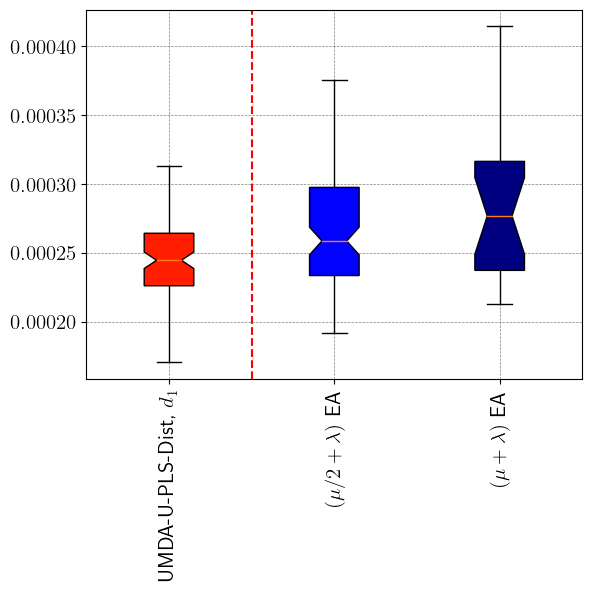

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `final-stat-increase-crop.pdf'.


[MannwhitneyuResult(statistic=3951.0, pvalue=0.005101331015197491),
 MannwhitneyuResult(statistic=596.0, pvalue=0.001976066651902808)]

In [17]:
stat_comp(('processedBig/umda2-dist_d0-2.csv', r'UMDA-U-PLS-Dist, $d_1$'), 
          [('processedBig/ea-simple-cross.csv', r'$(\mu/2 + \lambda)$ EA'),
           ('processedAfter-22-05-2024/ea-simple.csv', r'$(\mu + \lambda)$ EA'),
           ],
          2100,
          pdfname='final-stat-increase.pdf',
          styled=True, 
          rotation=90)

[(0, 0.00018494292954104993), (4, 0.00018875394066839198), (1, 0.00018933099276045908), (2, 0.00018995402783451517), (5, 0.00020265628113406016), (8, 0.00020376631926638495), (3, 0.00020593070081970164), (7, 0.00020941913441199108), (6, 0.0002095317018925523), (16, 0.00022691306964885456), (12, 0.00022840637343691747), (9, 0.00022943406665255979), (11, 0.00023412971473383716), (18, 0.0002369946076287957), (19, 0.00023707159142466322), (20, 0.00023723574069846583), (21, 0.00023857199010846072), (13, 0.00023915329291236508), (28, 0.00023967902809608939), (27, 0.00024119361844408414), (22, 0.00024153691198671465), (23, 0.00024208598125540038), (33, 0.00024248969979407398), (15, 0.00024333874480462613), (14, 0.00024384686149358164), (71, 0.00024447692123040536), (32, 0.0002446036739130881), (10, 0.00024519254375689534), (25, 0.0002457644658130678), (30, 0.0002466650333425951), (58, 0.0002495960047847396), (52, 0.0002499089641867581), (17, 0.00025131807607432614), (42, 0.0002533720678371969

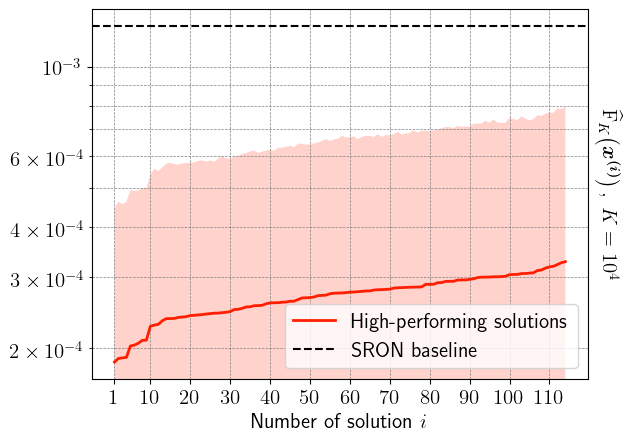

In [29]:
def doVisSolutions(filename):
    pdfname = 'sorted-solutions.pdf'
    design_ids = []
    nums = []
    designs_data = []
    color = name_to_color['UMDA-U-PLS-Dist, $d_1$']
    
    with open(filename, 'r') as file:
        for row in file:
            sp = row.split(' ')
            d0 = int(sp[0])
            d1 = int(sp[1])
            d2 = np.array([float(i) for i in sp[2:]])
            designs_data.append([d0, d1, d2])
            design_ids.append(d0)
            nums.append(d1)
    Objective = lambda x: np.mean(x**2)
    designs_data.sort(key=lambda d: Objective(d[2]))
    print([(d[0], Objective(d[2])) for d in designs_data])
    print(len(designs_data))
    fig = plt.figure()
    ax = plt.gca()    
    ax.set_yscale('log')
    objective_values = np.array([Objective(d[2]) for d in designs_data])
    std_dev = np.array([np.std(d[2]**2) for d in designs_data])
    x = np.arange(len(objective_values)) + 1
    plt.plot(x, objective_values, c=color, label='High-performing solutions', lw=2)
    ax.fill_between(x, objective_values - std_dev, objective_values + std_dev, facecolor=color, alpha=0.20)
    # ticks = []
    # ticks += np.arange(10, 115, 10)
    plt.xticks(np.concatenate([[1], np.arange(10, 115, 10)]))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.ylabel(r'$\Fest_K \! \left(\boldsymbol{x^{(i)}} \right), \; K = 10^4$', rotation=270, labelpad=25)
    plt.xlabel(r'Number of solution $i$')
    ax.axhline(y=sron_mean,color='black',linestyle='dashed', label='SRON baseline')
    # ax.fill_between(x, sron_mean - sron_std, sron_mean + sron_std, facecolor='black', alpha=0.20)
    ax.yaxis.set_label_position("right")
    plt.legend()
    fig.savefig(pdfname, bbox_inches='tight')
    subprocess.run(['pdfcrop', pdfname])


doVisSolutions('processedBig/results_umda2-dist_d0-2/top-umda2-dist_d0-2.csv')

In [15]:
cntr = None

PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `contours-crop.pdf'.


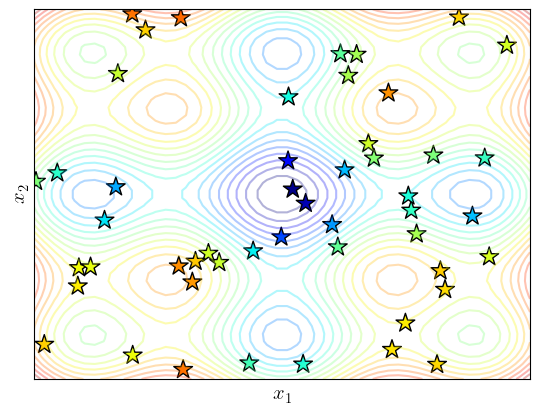

In [49]:
def rastrigin(x1, x2): # Rastrigin function
    x = np.array([x1, x2])
    N = len(x)
    # c = 2*math.pi
    c = 1.5
    return 10**(-3)*(10*N + sum(x[i]**2 - 10*math.cos(c*x[i]) for i in range(N)))


def isocountors_figure():
    global cntr
    basename = 'contours'
    fig, ax = plt.subplots()
    mycmap = mpl.cm.jet
    X = np.linspace(-5, 5, 50)
    Y = np.linspace(-5, 5, 50)
    X, Y = np.meshgrid(X, Y)
    Z = X.copy()
    for i in range(len(Z)):
        for j in range(len(Z[i])):
            Z[i][j] = rastrigin(X[i][j], Y[i][j])

    cntr = ax.contour(X, Y, Z, cmap=mycmap, extend='both', levels=20, alpha=0.3)

    N = 50
    np.random.seed(10)
    points = np.random.uniform(-5, 5, (2, N))
    cl = mycmap((np.array([rastrigin(*points[:, i]) for i in range(N)]) - Z.min())/(Z.max() - Z.min()))

    ax.scatter(points[0], points[1], c=cl, marker='*', s=200, edgecolors='k')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    plt.xticks([])
    plt.yticks([])

    # plt.colorbar(cntr, orientation='horizontal')   
    pdfname = basename + '.pdf'
    fig.savefig(pdfname)
    crop_pdf(pdfname)


isocountors_figure()


0 0.0001704647013529 16
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `transmission-0-crop.pdf'.


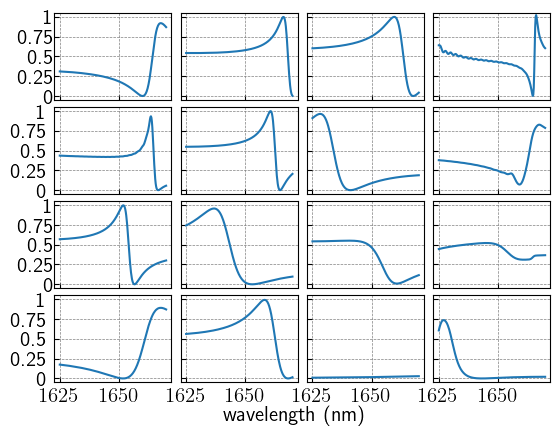

4 0.000185296625746 16
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `transmission-4-crop.pdf'.


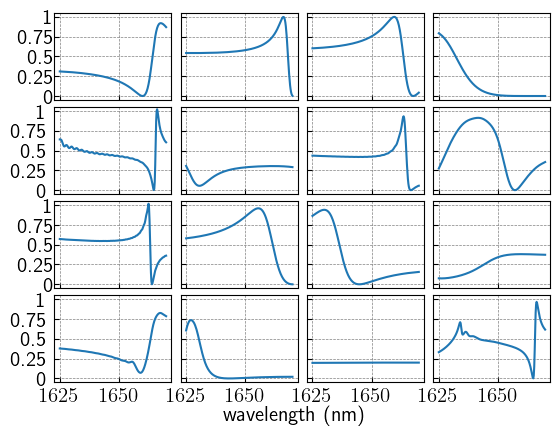

1 0.0001768075561706 16
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `transmission-1-crop.pdf'.


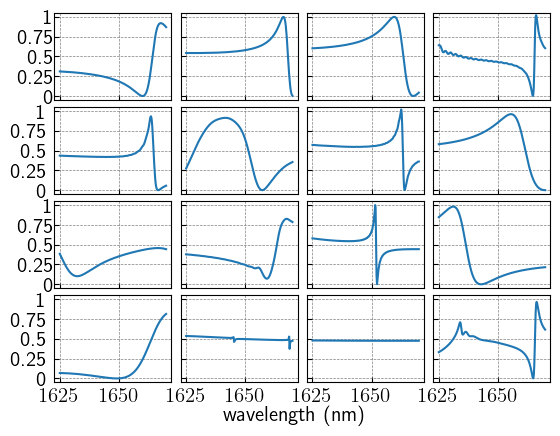

In [83]:

def visualize_transmission_profiles(F, dim_reducer, x_, p: tuple, filename):
    x = np.copy(x_)
    x.sort()
    F(x, 1)
    spectral_range = F.instrument.spectral_range
    selectedfilters = F.instrument.getTransmissionMatrix(x)
    original_profiles = [selectedfilters.T[:, i] for i in range(len(x))]
    profiles = np.zeros(dim_reducer.reduced_dim, dtype=np.ndarray)
    cnt = 0
    for i in range(dim_reducer.r):
        profiles[cnt] = (original_profiles[i * (dim_reducer.m + 1)])
        cnt += 1
    for i in range(dim_reducer.r, dim_reducer.reduced_dim):
        profiles[cnt] = original_profiles[i * dim_reducer.m]
        cnt += 1
    n, m = p
    sz = len(profiles)
    selection = dim_reducer.to_reduced(x)
    fig, axs = plt.subplots(n, m)
    plt.subplots_adjust(wspace=0.08, hspace=0.08)

    def get_axs(i, j):
        if n == 1 or m == 1:
            return axs[i + j]
        return axs[i, j]

    for i in range(n):
        for j in range(m):
            profile_number = i * m + j
            if profile_number < sz:
                get_axs(i, j).plot(spectral_range, profiles[profile_number], linewidth=1.5)
            if i != n - 1:
                get_axs(i, j).xaxis.set_ticklabels([])
            if j != 0:
                get_axs(i, j).yaxis.set_ticklabels([])
            if i % 2 == 1:
                pad = 6
            else:
                pad = 1
            get_axs(i, j).tick_params(axis="y",direction="in", pad=pad)
            get_axs(i, j).tick_params(axis="x",direction="in")
            get_axs(i, j).grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
            ticks = [0, 0.25, 0.5, 0.75, 1]
            get_axs(i, j).set_yticks(ticks)
            get_axs(i, j).set_ylim(-0.05, 1.05)
            if j == 0:
                get_axs(i, j).yaxis.set_ticklabels(ticks)
            # [i.set_linewidth(0.1) for i in get_axs(i, j).spines.values()]
            # get_axs(i, j).axis('off')
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    colors = ['red', 'blue', 'orange', 'purple', 'cyan', 'green']
    cnt = 0
    is_first = True
    cur_color = colors[0]
    for i in range(n):
        for j in range(m):
            profile_number = i * m + j
            if profile_number < sz:
                if profile_number < sz - 1 and selection[profile_number + 1] == selection[profile_number]:
                    if is_first:
                        cur_color = colors[cnt]
                        cnt = (cnt + 1) % len(colors)
                        is_first = False
                    [i.set_linewidth(2) for i in get_axs(i, j).spines.values()]
                    [i.set_edgecolor(cur_color) for i in get_axs(i, j).spines.values()]
                elif not is_first:
                    [i.set_linewidth(2) for i in get_axs(i, j).spines.values()]
                    [i.set_edgecolor(cur_color) for i in get_axs(i, j).spines.values()]
                    is_first = True

    fig.text(0.5, 0.03, 'wavelength (nm)', ha='center')
    # fig.text(0.03, 0.5, 'transmission', va='center', rotation='vertical')
    pdfname = f'{filename}.pdf'
    fig.savefig(pdfname)
    crop_pdf(pdfname)
    # plt.close()
    plt.show()


def doVisProfiles():
    dr = create_dim_red(16)
    df = pd.read_csv('processedBig/results_umda2-dist_d0-2/archive.csv', sep=' ', header=None)
    for k in [0, 4, 1]:
        row = df.iloc[k].tolist()
        obj_value, design = row[0], np.array([int(i) for i in row[1:]])
        print(k, obj_value, len(set(design)))
        visualize_transmission_profiles(Fr, dr, design, (4, 4), f'transmission-{k}')


doVisProfiles()